<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/Double_Pendulum_Solver_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Double Pendulum Simulator

Solving the Euler Lagrange equations for the double pendulum gives the second order differential equations:

$$ \begin{align} \ddot{\theta}_1 & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \dot{\theta}_1^2 \cos{(\theta_1 - \theta_2)} + \dot{\theta}_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \ddot{\theta}_2 & = \frac{2 \left[ \dot{\theta}_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \dot{\theta}_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$

Note that we have set mass and length of both sections to be 1. We need a system of first order differential equations. Thus, we will define $ \omega = \dot{\theta} $ for each section, thus giving us the system of equations:

$$ \begin{align} \frac{d \omega_1}{dt} & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \omega_1^2 \cos{(\theta_1 - \theta_2)} + \omega_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \frac{d \omega_2}{dt} & = \frac{2 \left[ \omega_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \omega_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$
 Plus the simpler equations:
 $$\begin{align} \frac{d \theta_1}{dt} & = \omega_1 \\ \frac{d \theta_2}{dt} & = \omega_2. \end{align} $$

In [1]:
import jax.numpy as jnp
from jax.numpy import pi, sin, cos
from jax import value_and_grad, jit
from jax import random
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import imageio
import time
from tqdm.auto import trange
from matplotlib.patches import Circle

perturb = False
perturbation = 0.1

# Generate random numbers for initialising angles
key, subkey = random.split(random.PRNGKey(int(time.time())))

# Define gravity
g = - 9.81

total_time = 20
dt = 0.001
dT = 0.01

In [2]:
# First make our initial conditions. We will set the angles to be random and the velocities to be 0.

theta_1_init = random.uniform(key, minval = 0, maxval = 2 * pi)
theta_2_init = random.uniform(subkey, minval = 0, maxval = 2 * pi)
omega_1_init = 0
omega_2_init = 0

y0 = jnp.array([theta_1_init, theta_2_init, omega_1_init, omega_2_init])

if perturb == True:
  Theta_1_init = theta_1_init + perturbation
  Theta_2_init = theta_2_init + perturbation
  Omega_1_init = 0
  Omega_2_init = 0

  Y0 = jnp.array([Theta_1_init, Theta_2_init, Omega_1_init, Omega_2_init])
# And generate our time array:

tsteps = jnp.linspace(0, int(total_time), int(total_time / dt))

$$ \begin{align} \frac{d \omega_1}{dt} & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \omega_1^2 \cos{(\theta_1 - \theta_2)} + \omega_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \frac{d \omega_2}{dt} & = \frac{2 \left[ \omega_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \omega_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$

In [3]:
@jit
def dy_dt(y, t, g):
  # Create return array and unpack the values of y:

  theta_1 = y[0] % (2 * pi)
  theta_2 = y[1] % (2 * pi)
  omega_1 = y[2]
  omega_2 = y[3]

  # Make the equations nicer by setting these:
  s = sin(theta_1 - theta_2)
  c = cos(theta_1 - theta_2)

  # Derivative of the thetas are just the omegas:
  dtheta1_dt = omega_1
  dtheta2_dt = omega_2

  # Derivative of the omegas:
  domega1_dt = ( g * sin(theta_2) * c - s * ((omega_1 ** 2) * c + (omega_2 ** 2)) - 2 * g * sin(theta_1) ) / (1 + s ** 2)

  domega2_dt = ( 2 * ( (omega_1 ** 2) * s - g * sin(theta_2) + g * sin(theta_1) * c ) + (omega_2 ** 2) * s * c ) / (1 + s ** 2)

  dy_dt = jnp.array([dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt])
  return dy_dt

In [4]:
jax_results = odeint(dy_dt, y0, tsteps, g)

if perturb == True:
  Jax_results = odeint(dy_dt, Y0, tsteps, g)

In [5]:
theta_1 = jax_results[:, 0]
theta_2 = jax_results[:, 1]

if perturb == True:
  Theta_1 = Jax_results[:, 0]
  Theta_2 = Jax_results[:, 1]

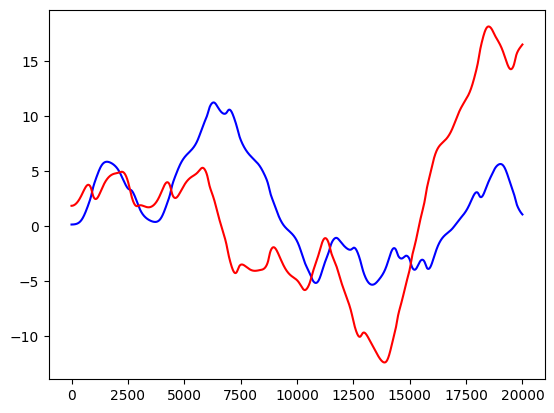

In [6]:
# Computes a plot of the angles.

plt.plot(theta_1, c='b')
plt.plot(theta_2, c='r')

Code below will convert the data into a gif.

0 / 200
1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200
95 / 200
96 / 200
97 / 200
98 / 200
99 / 200
100 / 200
101 / 200
102 / 200
103 / 200
104 / 200
105 / 200
106 / 200
107 / 200
108 / 200
109 / 200
110 / 200


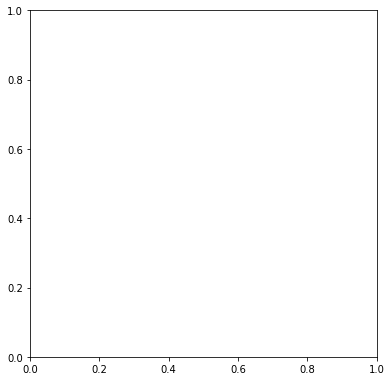

In [7]:
# Convert to Cartesian coordinates of the two bob positions.
x1 = sin(theta_1)
y1 = cos(theta_1)
x2 = x1 + sin(theta_2)
y2 = y1 + cos(theta_2)

if perturb == True:
  X1 = sin(Theta_1)
  Y1 = cos(Theta_1)
  X2 = X1 + sin(Theta_2)
  Y2 = Y1 + cos(Theta_2)

# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    if perturb == True:
      ax.plot([0, X1[i], X2[i]], [0, Y1[i], Y2[i]], lw=2, c='k')
      c3 = Circle((X1[i], Y1[i]), r, fc='g', ec='g', zorder=10)
      c4 = Circle((X2[i], Y2[i]), r, fc='y', ec='y', zorder=10)
      ax.add_patch(c3)
      ax.add_patch(c4)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

        if perturb == True:
          ax.plot(X2[imin:imax], Y2[imin:imax], c='y', solid_capstyle='butt',
                  lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-2-r, 2+r)
    ax.set_ylim(-2-r, 2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('img{:04d}.png'.format(i//di), dpi=72)
    plt.plot()
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, tsteps.size, di):
    print(i // di, '/', tsteps.size // di)
    make_plot(i)

In [8]:
frames = []
for i in range(int(tsteps.size) // di):
  image = imageio.v2.imread(f'img{i:04}.png')
  frames.append(image)

imageio
imageio.mimsave('./example.gif', # output gif
                frames,          # array of input frames
                fps = 10)         # optional: frames per second """

